# Model building and evaluation

## Dependencies loading

In [40]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss,roc_auc_score,precision_score,f1_score,recall_score,roc_curve,auc
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,fbeta_score,matthews_corrcoef
from sklearn import metrics
from sklearn import model_selection 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
#from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC 
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

## Data procesing

In [41]:
preprocessed_output_data_path = "../data/output"

df_train = pd.read_csv(f"{preprocessed_output_data_path}/train_fe.csv", index_col=0)
df_test = pd.read_csv(f"{preprocessed_output_data_path}/test_fe.csv", index_col=0)

In [42]:
# segregating dataset into features i.e., X and target variables i.e., y

# training data
X_train = df_train.drop(['target'],axis=1)
y_train = df_train['target']
# testing data
X_test = df_test.drop(['target'],axis=1)
y_test = df_test['target']

## Cross Validation

In this step, we will build different baseline models and perform 10-fold cross validation to filter top performing baseline models to be used in level 0 of stacked ensemble method.

In [43]:
# function initializing baseline machine learning models
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR_L2'   , LogisticRegression(penalty='l2')))
    basedModels.append(('KNN7'  , KNeighborsClassifier(7)))
    basedModels.append(('KNN5'  , KNeighborsClassifier(5)))
    basedModels.append(('KNN9'  , KNeighborsClassifier(9)))
    basedModels.append(('KNN11'  , KNeighborsClassifier(11)))
    basedModels.append(('SVM Linear'  , SVC(kernel='linear',gamma='auto',probability=True)))
    basedModels.append(('SVM RBF'  , SVC(kernel='rbf',gamma='auto',probability=True)))
    basedModels.append(('RF_Ent100'   , RandomForestClassifier(criterion='entropy',n_estimators=100)))
    basedModels.append(('RF_Gini100'   , RandomForestClassifier(criterion='gini',n_estimators=100)))
    
    return basedModels

# function for performing 10-fold cross validation of all the baseline models
def BasedLine2(X_train, y_train, models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'
    seed = 7
    results = []
    names = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
         
        
    return results,msg

In [44]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)

LR_L2: 0.829208 (0.030008)
KNN7: 0.848901 (0.039662)
KNN5: 0.826799 (0.056015)
KNN9: 0.841539 (0.040491)
KNN11: 0.824315 (0.042582)
SVM Linear: 0.830473 (0.039775)
SVM RBF: 0.842788 (0.035748)
RF_Ent100: 0.990184 (0.012054)
RF_Gini100: 0.991403 (0.012364)


## Model building

### Logistic Regression model

In [45]:
lrm = LogisticRegression()
lrm.fit(X_train,y_train)
y_pred_lrm = lrm.predict(X_test)

### K Neighbors Classifier

We can see KNN9 give the best result as compared with other KNN models, so let build the KNN model with K = 9

In [46]:
knn = KNeighborsClassifier(9)
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

### Support Vector Classifier

We can see SVC with kernel = rbf give the better result as compared kernel = linear, so let build the SVC model with kernel = rbf

In [47]:
svc = SVC(kernel='rbf',gamma='auto',probability=True)
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)

### Random Forest Classifier

We can see RF model with criterion='gini' and n_estimators=100 give better result, so let build this model

In [48]:
rfg = RandomForestClassifier(criterion='gini',n_estimators=100)
rfg.fit(X_train, y_train)
y_pred_rfg = rfg.predict(X_test)

## Model evaluation

In this part, we will use below evaluation metrics to evaluate our models:
- Accuracy
- Precision
- Sensitivity
- Specificity
- F1 Score
- ROC
- Log_Los
- Matthews Correlation Coefficient

As we can see in above cross validation step, the Random Forest Classifier with criterion='gini' and n_estimators=100 give the best result. So, let start with this model

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef
0,RF,0.955882,0.939655,0.981982,0.924731,0.960352,0.953357,1.590161,0.911806


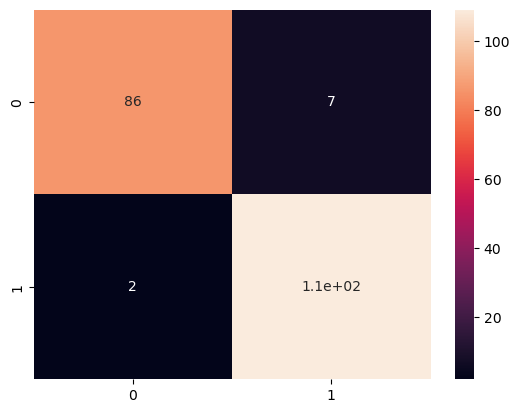

In [49]:
CM=confusion_matrix(y_test,y_pred_rfg)
sns.heatmap(CM, annot=True)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)
loss_log = log_loss(y_test, y_pred_rfg)
acc= accuracy_score(y_test, y_pred_rfg)
roc=roc_auc_score(y_test, y_pred_rfg)
prec = precision_score(y_test, y_pred_rfg)
rec = recall_score(y_test, y_pred_rfg)
f1 = f1_score(y_test, y_pred_rfg)

mathew = matthews_corrcoef(y_test, y_pred_rfg)
model_results =pd.DataFrame([['RF',acc, prec,rec,specificity, f1,roc, loss_log,mathew]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score','ROC','Log_Loss','mathew_corrcoef'])

model_results

And compare with other models

In [50]:
data = {        'LR': y_pred_lrm, 
                'KNN': y_pred_knn,  
                'SVC': y_pred_svc}

models = pd.DataFrame(data) 
 
for column in models:
    CM=confusion_matrix(y_test,models[column])
    
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    specificity = TN/(TN+FP)
    loss_log = log_loss(y_test, models[column])
    acc= accuracy_score(y_test, models[column])
    roc=roc_auc_score(y_test, models[column])
    prec = precision_score(y_test, models[column])
    rec = recall_score(y_test, models[column])
    f1 = f1_score(y_test, models[column])
    
    mathew = matthews_corrcoef(y_test, models[column])
    results =pd.DataFrame([[column,acc, prec,rec,specificity, f1,roc, loss_log,mathew]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score','ROC','Log_Loss','mathew_corrcoef'])
    model_results = pd.concat([model_results, pd.DataFrame(results)], ignore_index = True)

model_results

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score,ROC,Log_Loss,mathew_corrcoef
0,RF,0.955882,0.939655,0.981982,0.924731,0.960352,0.953357,1.590161,0.911806
1,LR,0.887255,0.885965,0.909910,0.860215,0.897778,0.885062,4.063745,0.772486
2,KNN,0.872549,0.869565,0.900901,0.838710,0.884956,0.869805,4.593799,0.742783
3,SVC,0.872549,0.863248,0.909910,0.827957,0.885965,0.868933,4.593799,0.743068


All the evaluation metrics show the best result for Random Forest Classifier model

Let plot the ROC AUC Curve

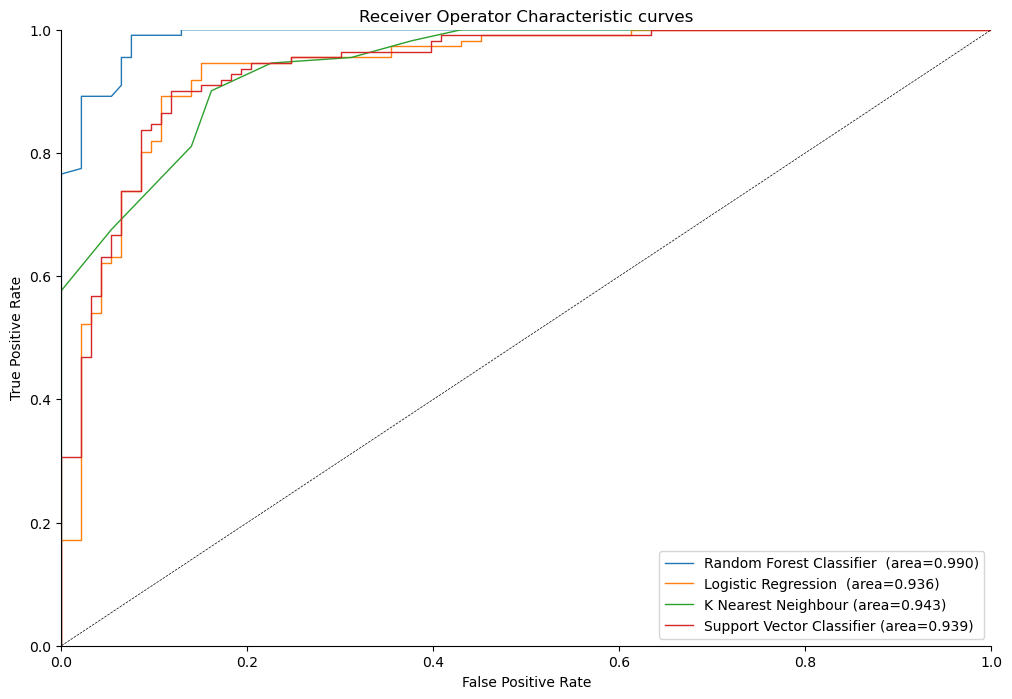

In [51]:
def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_proba[:,1])
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (area=%.3f)"%(label,roc_auc_score(y_true, y_proba[:,1])))

f, ax = plt.subplots(figsize=(12,8))


roc_auc_plot(y_test,rfg.predict_proba(X_test),label='Random Forest Classifier ',l='-')
roc_auc_plot(y_test,lrm.predict_proba(X_test),label='Logistic Regression ',l='-')
roc_auc_plot(y_test,knn.predict_proba(X_test),label='K Nearest Neighbour',l='-')
roc_auc_plot(y_test,svc.predict_proba(X_test),label='Support Vector Classifier',l='-')

ax.plot([0,1], [0,1], color='k', linewidth=0.5, linestyle='--', 
        )    
ax.legend(loc="lower right")    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Receiver Operator Characteristic curves')
sns.despine()

And vizualize precision

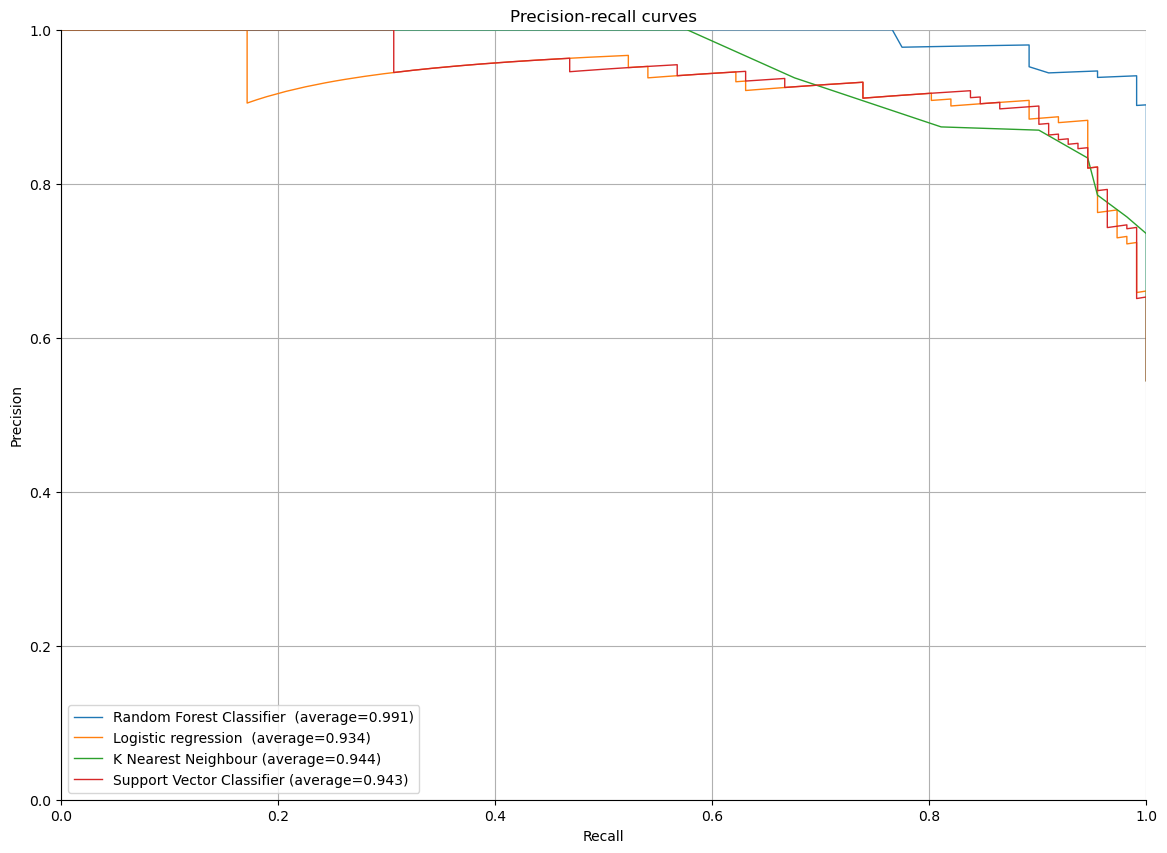

In [52]:
def precision_recall_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_test,
                                                  y_proba[:,1])
    average_precision = average_precision_score(y_test, y_proba[:,1],
                                                     average="micro")
    ax.plot(recall, precision, label='%s (average=%.3f)'%(label,average_precision),
            linestyle=l, linewidth=lw)

f, ax = plt.subplots(figsize=(14,10))

precision_recall_plot(y_test,rfg.predict_proba(X_test),label='Random Forest Classifier ',l='-')
precision_recall_plot(y_test,lrm.predict_proba(X_test),label='Logistic regression ',l='-')
precision_recall_plot(y_test,knn.predict_proba(X_test),label='K Nearest Neighbour',l='-')
precision_recall_plot(y_test,svc.predict_proba(X_test),label='Support Vector Classifier',l='-')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc="lower left")
ax.grid(True)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Precision-recall curves')
sns.despine()

## Conclusion

Random Forest Classifier give the best result for predicting heart disease as compared to Logistic Regression, Support Vector Classifier and K Nearest Neighbours models